# Today
- decide if we want to inspect sentences from training
- for ovv remove from list of words in training and test also words from glove, other than the ones in training
- can we split compound terms?

# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199
### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.
### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.
### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)
### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.
### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).
### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

In [2]:
import sys
import shutil
import urllib
import os

import zipfile
from pathlib import Path
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from typing import Iterable, List, Callable, Dict
from tqdm import tqdm
import random
import tensorflow as tf
import keras



seed = 812

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tf.config.experimental.enable_op_determinism()
# Set environment variable for TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [3]:
glorot_normal_1 = keras.initializers.GlorotNormal(seed=seed)
glorot_normal_2 = keras.initializers.GlorotNormal(seed=seed)

input_dim, neurons = 3, 5

# Call two different objects with same shape
result_1 = glorot_normal_1(shape=(input_dim, neurons))
result_2 = glorot_normal_2(shape=(input_dim, neurons))
print(result_1)
print(result_2)
# Check if the results are equal.
equal = np.allclose(result_1, result_2)
print(f"Are the results equal? {equal}")

tf.Tensor(
[[-0.6387855  -0.89870685  0.07983305  0.19414163 -0.76766497]
 [-0.38364235  0.4428017   0.6928357  -0.8514683   0.09465076]
 [ 0.21068816  0.3536609  -0.43506557 -1.0789914   0.34279203]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[-0.6387855  -0.89870685  0.07983305  0.19414163 -0.76766497]
 [-0.38364235  0.4428017   0.6928357  -0.8514683   0.09465076]
 [ 0.21068816  0.3536609  -0.43506557 -1.0789914   0.34279203]], shape=(3, 5), dtype=float32)
Are the results equal? True


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_dataset(download_path: Path, url: str):
    response = requests.get(url)
    with open(download_path, 'wb') as f:
        f.write(response.content)

def download_url(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed!")

In [6]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)

Current work directory: /kaggle/working
Extracting dataset... (it may take a while...)
Extraction completed!


In [7]:
folder = dataset_folder.joinpath(dataset_name)
folder

PosixPath('/kaggle/working/Datasets/dependency_treebank')

In [8]:
# Initialize an empty list to store the data rows
dataframe_rows = []
index = 0
tag_set = set([])
# Iterate through the files in the directory with the '.dp' extension
for file_path in folder.glob('*.dp'):
#file_path = folder.joinpath('wsj_0001.dp')
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        index+=1
        sentence =  '' # word1 + word2
        tag = []
        lines = text_file.readlines()
        # Split the line by whitespace to separate columns
        for line in lines:
            line_parts = line.split('\t')
            if len(line_parts) == 1: #case '\n'
                dataframe_row = {
                    "sentence": sentence,
                    "POS": tag,
                    "index": index,
                    "split": 'train' if index <=100 else  'validation' if index<=150 else 'test'
                }
                dataframe_rows.append(dataframe_row)
                sentence =  ''
                tag = []
            else:
                sentence += line_parts[0] + " "
                tag.append(line_parts[1])
                tag_set.add(line_parts[1])
        # Last sentence
        dataframe_row = {
                    "sentence": sentence,
                    "POS": tag,
                    "index": index,
                    "split": 'train' if index <=100 else  'validation' if index<=150 else 'test'
                }
        dataframe_rows.append(dataframe_row)
# Create a Pandas DataFrame
df = pd.DataFrame(dataframe_rows)
df.to_pickle(folder.with_name(dataset_name + ".pkl"))

In [9]:
# Initialize an empty list to store the data rows
dataframe_rows = []
# Iterate through the files in the directory with the '.dp' extension
for file_path in folder.glob('*.dp'):
#file_path = folder.joinpath('wsj_0001.dp')
    file_sentences =  [] # word1 + word2
    tag = []
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        lines = text_file.readlines()
        # Split the line by whitespace to separate columns
        for line in lines:
            line_parts = line.split('\t')
            if len(line_parts) != 1: #case '\n'
                file_sentences.append(line_parts[0])
                tag.append(line_parts[1])
        # Last sentence
        dataframe_row = {
                    "sentence": file_sentences,
                    "POS": tag,
                }
        dataframe_rows.append(dataframe_row)
# Create a Pandas DataFrame
df_file = pd.DataFrame(dataframe_rows)

In [10]:
df_file

,sentence,POS
0,"[Travelers, Corp., 's, third-quarter, net, inc...","[NNPS, NNP, POS, NN, NN, NN, VBD, CD, NN, ,, R..."
1,"[Tony, Lama, Co., said, that, Equus, Investmen...","[NNP, NNP, NNP, VBD, IN, NNP, NNP, NNP, NNP, N..."
2,"[The, U.S., and, Soviet, Union, are, holding, ...","[DT, NNP, CC, NNP, NNP, VBP, VBG, JJ, NNS, IN,..."
3,"[INTER-TEL, Inc, ., -LRB-, Chandler, ,, Ariz.,...","[NNP, NNP, ., -LRB-, NNP, ,, NNP, -RRB-, :, NN..."
4,"[ORTEGA, ENDED, a, truce, with, the, Contras, ...","[NNP, VBD, DT, NN, IN, DT, NNPS, CC, VBD, NNS,..."
...,...,...
194,"[John, F., Barrett, ,, 40, ,, formerly, execut...","[NNP, NNP, NNP, ,, CD, ,, RB, JJ, NN, NN, CC, ..."
195,"[A, man, from, the, Bush, administration, came...","[DT, NN, IN, DT, NNP, NN, VBD, IN, DT, NNP, NN..."
196,"[Bank, of, New, England, Corp., said, it, has,...","[NNP, IN, NNP, NNP, NNP, VBD, PRP, VBZ, VBN, N..."
197,"[Meridian, National, Corp., said, it, sold, 75...","[NNP, NNP, NNP, VBD, PRP, VBD, CD, NNS, IN, PR..."


In [11]:
df

,sentence,POS,index,split
0,Travelers Corp. 's third-quarter net income ro...,"[NNPS, NNP, POS, NN, NN, NN, VBD, CD, NN, ,, R...",1,train
1,"Net advanced to $ 94.2 million , or 89 cents a...","[NN, VBD, TO, $, CD, CD, ,, CC, CD, NNS, DT, N...",1,train
2,But revenue declined to $ 3 billion from $ 3.2...,"[CC, NN, VBD, TO, $, CD, CD, IN, $, CD, CD, .]",1,train
3,Travelers estimated that the California earthq...,"[NNPS, VBD, IN, DT, NNP, NN, JJ, NN, MD, VB, I...",1,train
4,The insurer 's earnings from commercial proper...,"[DT, NN, POS, NNS, IN, JJ, NN, NNS, VBD, CD, N...",1,train
...,...,...,...,...
3909,"When Scoring High first came out in 1979 , it ...","[WRB, NNP, NNP, RB, VBD, RB, IN, CD, ,, PRP, V...",199,test
3910,McGraw-Hill was outraged .,"[NNP, VBD, JJ, .]",199,test
3911,"In a 1985 advisory to educators , McGraw-Hill ...","[IN, DT, CD, NN, TO, NNS, ,, NNP, VBD, NNP, NN...",199,test
3912,"But in 1988 , McGraw-Hill purchased the Random...","[CC, IN, CD, ,, NNP, VBD, DT, NNP, NNP, NN, WD...",199,test


In [12]:
#test for same lengths in sentences and POS
different_length = [1 if len(input.split()) != len(output) else 0 for input, output in zip(df['sentence'].values, df['POS'])]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [13]:
#dictionaries with all the tags in the corpus
treebank_index_to_tag = {}
treebank_tag_to_index = {}
index = 1
for tag in tag_set:
    treebank_index_to_tag[index] = tag
    treebank_tag_to_index[tag] = index
    index+=1
print(treebank_index_to_tag)
print(treebank_tag_to_index)

{1: "''", 2: 'CC', 3: 'WDT', 4: 'LS', 5: '-RRB-', 6: 'VBN', 7: 'PRP', 8: 'RP', 9: 'CD', 10: 'FW', 11: 'TO', 12: ':', 13: 'VBZ', 14: 'PRP$', 15: 'MD', 16: 'JJS', 17: '$', 18: '``', 19: '.', 20: 'NN', 21: 'SYM', 22: 'POS', 23: 'NNP', 24: 'VB', 25: 'NNS', 26: 'WRB', 27: 'VBD', 28: 'JJR', 29: 'VBP', 30: '#', 31: 'RB', 32: '-LRB-', 33: 'RBR', 34: 'VBG', 35: 'UH', 36: 'NNPS', 37: 'EX', 38: 'IN', 39: 'WP', 40: 'PDT', 41: 'WP$', 42: ',', 43: 'JJ', 44: 'RBS', 45: 'DT'}
{"''": 1, 'CC': 2, 'WDT': 3, 'LS': 4, '-RRB-': 5, 'VBN': 6, 'PRP': 7, 'RP': 8, 'CD': 9, 'FW': 10, 'TO': 11, ':': 12, 'VBZ': 13, 'PRP$': 14, 'MD': 15, 'JJS': 16, '$': 17, '``': 18, '.': 19, 'NN': 20, 'SYM': 21, 'POS': 22, 'NNP': 23, 'VB': 24, 'NNS': 25, 'WRB': 26, 'VBD': 27, 'JJR': 28, 'VBP': 29, '#': 30, 'RB': 31, '-LRB-': 32, 'RBR': 33, 'VBG': 34, 'UH': 35, 'NNPS': 36, 'EX': 37, 'IN': 38, 'WP': 39, 'PDT': 40, 'WP$': 41, ',': 42, 'JJ': 43, 'RBS': 44, 'DT': 45}


**Section 2:**

Text pre-processing, Lemmatization, (Stemming ?)

In [14]:
from functools import reduce
from nltk.corpus import stopwords

def lower(text: str) -> str:
    return text.lower() # lower casing words

PREPROCESSING_PIPELINE = [
                          lower
                        ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [15]:
print(f'[Debug] Before:\n{df.sentence.values[50]}')
df['sentence'] = df['sentence'].apply(lambda txt: text_prepare(txt))
print(f'[Debug] After:\n{df.sentence.values[50]}')
#maybe convert also POS into lower case

[Debug] Before:
Gunmen in Lebanon assassinated a Saudi Arabian Embassy employee , and the pro-Iranian Islamic Jihad took responsibility for the slaying to avenge the beheading of 16 terrorists by Riyadh 's government in September . 
[Debug] After:
gunmen in lebanon assassinated a saudi arabian embassy employee , and the pro-iranian islamic jihad took responsibility for the slaying to avenge the beheading of 16 terrorists by riyadh 's government in september . 


In [16]:
from collections import OrderedDict
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str],
                                           Dict[str, int],
                                           List[str]): # builds the vocabulary of the dataset

    idx_to_word = OrderedDict() # vocabulary index to word map
    word_to_idx = OrderedDict() # word to vocabulary index map (inverse of idx_to_word)

    curr_idx = 0
    for sentence in tqdm(df.sentence.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values()) # set of unique terms that make up the vocabulary
    return idx_to_word, word_to_idx, word_listing

In [17]:
idx_to_word_corpus, word_to_idx_corpus, word_listing_corpus = build_vocabulary(df)
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word_corpus)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx_corpus)}')
print(f'[Debug] Some words: {[(idx_to_word_corpus[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 3914/3914 [00:00<00:00, 164301.43it/s]

[Debug] Index -> Word vocabulary size: 10947
[Debug] Word -> Index vocabulary size: 10947
[Debug] Some words: [('corp.', 1), ("'s", 2), ('third-quarter', 3), ('net', 4), ('income', 5), ('rose', 6), ('11', 7), ('%', 8), (',', 9), ('even', 10)]


In [18]:
idx_to_word_train, word_to_idx_train, word_listing_train = build_vocabulary(df[df['split']=='train'])
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word_train)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx_train)}')
print(f'[Debug] Some words in training: {[(idx_to_word_train[idx], idx) for idx in np.arange(10) + 1]}')

100%|██████████| 2143/2143 [00:00<00:00, 125497.66it/s]

[Debug] Index -> Word vocabulary size: 7621
[Debug] Word -> Index vocabulary size: 7621
[Debug] Some words in training: [('corp.', 1), ("'s", 2), ('third-quarter', 3), ('net', 4), ('income', 5), ('rose', 6), ('11', 7), ('%', 8), (',', 9), ('even', 10)]


In [19]:
_, _, word_listing_val_and_test = build_vocabulary(df[df['split']!='train'])
print(f'[Debug] vocabulary size validation and test: {len(word_listing_val_and_test)}')

100%|██████████| 1771/1771 [00:00<00:00, 95020.24it/s]

[Debug] vocabulary size validation and test: 6781


In [20]:
words_in_train_set = set(word_listing_train)
words_in_val_and_test_set = set(word_listing_val_and_test)
oov = set(words_in_val_and_test_set).difference(words_in_train_set)
print('words in training set:',len(words_in_train_set))
print('words in validation and test set:',len(words_in_val_and_test_set))
print('words not present in training set:',len(oov))
print('size vocabulary of corpus', len(word_listing_corpus))
print('size vocabulary of corpus', len(words_in_train_set)+len(oov))


words in training set: 7621
words in validation and test set: 6781
words not present in training set: 3326
size vocabulary of corpus 10947
size vocabulary of corpus 10947


In [21]:
# Check size, content, consistency and toy example
def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'sentence': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.sentence.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary

In [22]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_corpus, word_to_idx_corpus, word_listing_corpus, df)
print("Evaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 10947/10947 [00:00<00:00, 1334274.26it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 3914/3914 [00:00<00:00, 153136.19it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 7294.44it/s]


Evaluation completed!


In [23]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:  #50,100,200
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model

In [24]:
embedding_model_50 = load_embedding_model(embedding_dimension=50)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [25]:
embedding_model_100 = load_embedding_model(embedding_dimension=100)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [26]:
embedding_model_200 = load_embedding_model(embedding_dimension=200)

[==================================================] 100.0% 252.1/252.1MB downloaded


In [27]:
embedding_model_300 = load_embedding_model(embedding_dimension=300)

[=================================================-] 100.0% 375.9/376.1MB downloaded


In [28]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [29]:
# this should be the number of oov from val and test
embedding_vocabulary = set(embedding_model_50.key_to_index.keys())
oov_terms = oov.difference(embedding_vocabulary) #words that appear only in val and test
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing_val_and_test)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 292 (4.31%)


In [30]:
# dictionary for oov to use for static embedding
index = 0 #1+len(oov_terms) #here we used word_listing_train instead of oov_terms to start from the last index of the vocabulary
oov_to_index_dict = {}
index_to_oov_dict = {}
for oov in oov_terms:
    oov_to_index_dict[oov] = index
    index_to_oov_dict[index] = oov
    index+=1
print('Size OOV dictionary',len(index_to_oov_dict))
print('Same size', len(oov_to_index_dict) == len(index_to_oov_dict))

Size OOV dictionary 292
Same size True


In [31]:
oov_terms_train = check_OOV_terms(embedding_model_50, word_listing_train) #words to embed
oov_percentage_train = float(len(oov_terms_train)) * 100 / len(word_listing_train)
print(f"Total OOV terms: {len(oov_terms_train)} ({oov_percentage_train:.2f}%)")

Total OOV terms: 384 (5.04%)


In [32]:
new_POS_list = [[treebank_tag_to_index[tag] for tag in tags] for tags in df['POS']]


In [33]:
#Vocabulary without oov
word_listing = list(set(word_listing_corpus) - oov_terms)
word_listing.append('UNK')
word_listing.insert(0, (' '))  #may cause an error!!!
print(len(word_listing),len(word_listing_corpus),len(oov_terms),len(word_listing_corpus)-len(oov_terms))
index=0
idx_to_word = {}
word_to_idx = {}
for word in word_listing:
    idx_to_word[index] = word
    word_to_idx[word] = index
    index+=1
print('Same length',len(word_to_idx)==len(idx_to_word))
print('Same length',len(word_listing)==len(idx_to_word))

10657 10947 292 10655
Same length True
Same length True


In [34]:
sentences = []

for sentence in df[df['split'] == 'train'].sentence:
    sentences.append(sentence)

for sentence in df[df['split'] != 'train'].sentence:
    words = sentence.split()
    modified_words = [word if word not in oov_terms else 'UNK' for word in words]
    modified_sentence = ' '.join(modified_words)
    sentences.append(modified_sentence)
print('Num of sentences: ',len(sentences))

Num of sentences:  3914


In [35]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: Dict[str,int] = None) -> np.ndarray:
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        if word == 'UNK':
            embedding_matrix[idx] = np.zeros(embedding_dimension)
        else:
            try:
                embedding_vector = embedding_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [36]:
# Testing
embedding_matrix_50 = build_embedding_matrix(embedding_model_50, 50, word_to_idx, len(word_to_idx))
embedding_matrix_100 = build_embedding_matrix(embedding_model_100, 100, word_to_idx, len(word_to_idx))
embedding_matrix_200 = build_embedding_matrix(embedding_model_200, 200, word_to_idx, len(word_to_idx))
embedding_matrix_300 = build_embedding_matrix(embedding_model_300, 300, word_to_idx, len(word_to_idx))

print(f"Embedding matrix shape: {embedding_matrix_50.shape}")

100%|██████████| 10657/10657 [00:00<00:00, 231553.88it/s]

Embedding matrix shape: (10657, 50)


In [37]:
encoded_sentences = [[word_to_idx[word] for word in sentence.split()] for sentence in sentences]

Length of longest sentence: 1265
Amount of sentences: 3914


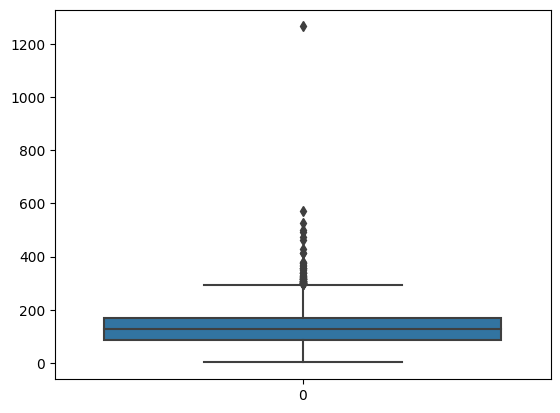

In [38]:
# check length of longest sentence
lengths = [len(seq) for seq in df['sentence']]
padding_length = 600
print("Length of longest sentence: {}".format(max(lengths)))
print("Amount of sentences: {}".format((len(lengths))))
sns.boxplot(lengths)
plt.show()

Length of longest sentence: 4534
Amount of sentences: 199


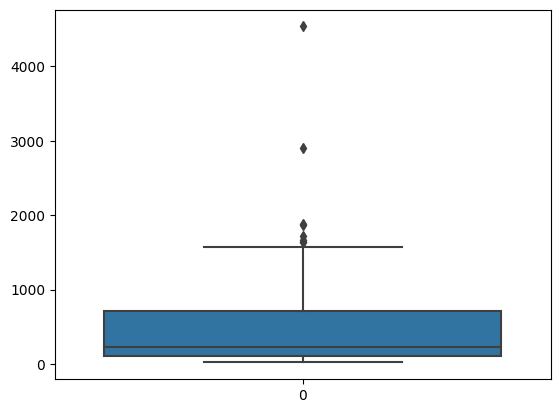

In [39]:
#df_file
lengths_file = [len(seq) for seq in df_file['sentence']]
padding_length = 600
print("Length of longest sentence: {}".format(max(lengths_file)))
print("Amount of sentences: {}".format((len(lengths_file))))
sns.boxplot(lengths_file)
plt.show()

In [40]:
np_len = np.array(lengths)
print(np_len.shape)
phrases = [seq for seq in df['sentence']]
print(len(phrases))
positions = np_len > 600
print(positions)
#print(sum(np_len < 200))
looooong_sentences = []
for i in range(np_len.shape[0]):
    if positions[i]:
        looooong_sentences.append(phrases[i])
print(looooong_sentences)

for i in range(len(phrases)):
    if phrases[i] == looooong_sentences[0]:
        print(i)

(3914,)
3914
[False False False ... False False False]
['the following were barred or , where noted , suspended and consented to findings without admitting or denying wrongdoing : edward l. cole , jackson , miss. , $ 10,000 fine ; rita rae cross , denver , $ 2,500 fine and 30-day suspension ; thomas richard meinders , colorado springs , colo. , $ 2,000 fine , five-day suspension and eight-month suspension as a principal ; ronald a. cutrer , baton rouge , la. , $ 15,000 fine and one-month suspension ; karl grant hale , midvale , utah , $ 15,000 fine ; clinton p. hayne , new orleans , $ 7,500 fine and one-week suspension ; richard m. kane , coconut creek , fla. , $ 250,000 fine ; john b. merrick , aurora , colo. , $ 1,000 fine and 10-day suspension ; john p. miller , baton rouge , $ 2,000 fine and two-week suspension ; randolph k. pace , new york , $ 10,000 fine and 90-day suspension ; brian d. pitcher , new providence , n.j. , $ 30,000 fine ; wayne a. russo , bridgeville , pa. , $ 4,000

In [41]:
from keras.utils import pad_sequences
padded_sentences = pad_sequences(
    encoded_sentences,
    maxlen=padding_length,
    padding='pre',
    truncating='pre',
    value=0 #his should be the space
)
padded_POS = pad_sequences(
    new_POS_list,
    maxlen=padding_length,
    padding='pre',
    truncating='pre',
    value=0#10631
)

In [42]:
# padded_sentences phrase x padding+real length
#df_POS_new
from keras.utils import to_categorical
training_samples = df[df['split']=='train'].count().sentence
validation_samples = df[df['split']=='validation'].count().sentence
validation_samples+=training_samples

X_train = padded_sentences[:training_samples,:]
Y_train = to_categorical(padded_POS[:training_samples,:])
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

X_val = padded_sentences[training_samples:validation_samples,:]
Y_val = to_categorical(padded_POS[training_samples:validation_samples,:])
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

X_test = padded_sentences[validation_samples:,:]
Y_test = to_categorical(padded_POS[validation_samples:,:])
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [43]:
variables = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_val": X_val,
    "Y_val": Y_val,
    "X_test": X_test,
    "Y_test": Y_test,
    "embedding_matrix": embedding_matrix_50
}

for name, value in variables.items():
    print(f"{name}.shape:", value.shape)

X_train.shape: (2143, 600)
Y_train.shape: (2143, 600, 46)
X_val.shape: (985, 600)
Y_val.shape: (985, 600, 46)
X_test.shape: (786, 600)
Y_test.shape: (786, 600, 46)
embedding_matrix.shape: (10657, 50)


In [44]:
treebank_index_to_tag[0] = ' '
treebank_tag_to_index[' '] = 0
punctuations_indeces = [0,27,36,41,42,43]

In [45]:
import keras.backend as K
def macro_f1_score(num_classes, ignore_class_indices):
    def f1(y_true, y_pred):
        f1_scores = []
        for i in range(num_classes):
            if i not in ignore_class_indices:
                true_positives = K.sum(K.cast(y_true[:, :, i] * y_pred[:, :, i], 'float32'))
                possible_positives = K.sum(K.cast(y_true[:, :, i], 'float32'))
                predicted_positives = K.sum(K.cast(y_pred[:, :, i], 'float32'))

                precision = true_positives / (predicted_positives + K.epsilon())
                recall = true_positives / (possible_positives + K.epsilon())

                f1 = 2 * (precision * recall) / (precision + recall + K.epsilon()) if (precision + recall) > K.epsilon() else 0.0
                f1_scores.append(f1)

        macro_f1 = K.mean(K.stack(f1_scores), axis=0)
        return macro_f1
    return f1

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = len(word_to_idx),
                             output_dim    = 50,
                             input_length  = padding_length,
                             weights       = [embedding_matrix_50],
                             trainable     = False
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax'))) #test if adding whitespace to vocabulary makes some differences
# Compile the model
bidirect_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=[macro_f1_score(num_classes=len(treebank_index_to_tag), ignore_class_indices=punctuations_indeces)])

# Display the model summary
bidirect_model.summary()

NameError: name 'embedding_dimension' is not defined

In [ ]:
history_bidirectional_model = bidirect_model.fit(train_dataset, epochs=3, validation_data=validation_dataset)

In [ ]:
# Evaluate the model, which will use the custom F1 score metric that ignores punctuation
loss, f1 = bidirect_model.evaluate(test_dataset, verbose=1)

# Print the loss and macro F1 score
print("Loss: {0},\nMacro F1 Score: {1}".format(loss, f1))

In [48]:
embedding_matrix_50[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [54]:
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam, RMSprop, SGD
import numpy as np

# Define hyperparameters
embedding_matrices = [embedding_matrix_50, embedding_matrix_100, embedding_matrix_200, embedding_matrix_300] # build the actual matrices
optimizers = [Adam, RMSprop, SGD]
batch_sizes = [32, 64, 128]
lstm_sizes = [32, 64, 128]
embedding_training_bool = [True,False]
learning_rates = [0.001, 0.01, 0.1]  # first one standard

# Create a function to build and compile the model with given hyperparameters
def build_model(embedding_matrix, embedding_trainable_bool, lstm_size,optimizer,learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim= len(word_to_idx),
                        output_dim    = embedding_matrix.shape[-1],
                        input_length  = padding_length,
                        weights       = [embedding_matrix],
                        trainable     = embedding_trainable_bool
    ))    
    model.add(Bidirectional(LSTM(units=lstm_size, return_sequences=True)))
    model.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))
    model.compile(optimizer=optimizer(learning_rate=learning_rate),loss='categorical_crossentropy',
                       metrics=[macro_f1_score(num_classes=len(treebank_index_to_tag), ignore_class_indices=punctuations_indeces)])
    return model


# Grid search loop
best_f1 = 0
best_params = {}
for (embedding_matrix, emb_training_bool, lstm_size, optimizer, learning_rate, batch_size) in product(embedding_matrices, embedding_training_bool, lstm_sizes, optimizers, learning_rates, batch_sizes):
    model = build_model(embedding_matrix, emb_training_bool, lstm_size,optimizer,learning_rate)
    
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train),seed=seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    history_model = model.fit(train_dataset, epochs=40, validation_data=validation_dataset)
    f1 = np.max(history_model.history['f1'])
    if f1 > best_f1:
        best_f1 = f1
        best_params = {
            'trainability embedding': emb_training_bool,
            'lstm_size': lstm_size,
            'embedding_matrix_shape': embedding_matrix.shape,
            'optimizer': optimizer, 
            'learning_rate':learning_rate,
            'batch_size': batch_size
        }

print("Best f1:", best_f1)
print("Best hyperparameters:", best_params)


Epoch 1/40
67/67 [==============================] - 50s 623ms/step - loss: 1.3109 - f1: 0.0070 - val_loss: 0.1538 - val_f1: 0.0140


KeyboardInterrupt: 

In [ ]:
wadawd

In [ ]:
history_bidirectional_model = bidirect_model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_val, Y_val))

In [ ]:
# Evaluate the model, which will use the custom F1 score metric that ignores punctuation
loss, f1 = bidirect_model.evaluate(X_test, Y_test, verbose=1)

# Print the loss and macro F1 score
print("Loss: {0},\nMacro F1 Score: {1}".format(loss, f1))

In [ ]:
y_true_classes = np.argmax(Y_test, axis=-1)
y_true_classes.shape

In [ ]:
index_to_tag

In [ ]:
from collections import Counter
y_pred = bidirect_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
print(y_pred_classes.shape)

y_true_classes = np.argmax(Y_test, axis=-1)
y_pred_classes_flat = y_pred_classes.flatten()

y_true_classes_flat = y_true_classes.flatten()

index_to_word = {v: k for k, v in word_to_idx.items()}
index_to_tag = {v: k for k, v in treebank_index_to_tag.items()}
misclassified = []
for (pred, true) in zip(y_pred_classes_flat, y_true_classes_flat):
    if pred != true:
        #word_index = X_test[i // padding_length][i % padding_length]
        #word = index_to_word[word_index]
        true_tag = treebank_index_to_tag[pred]
        pred_tag = treebank_index_to_tag[true]
        misclassified.append((true_tag, pred_tag)) # (predicted_tag, true_tag, sentence_number, position_inside_sentence)


#Count occurrences of each misclassified pair
misclassification_counter = Counter(misclassified)

#Get the most common misclassified pairs
most_common_misclassifications = misclassification_counter.most_common()

#Print or process the most common misclassifications
for pair, count in most_common_misclassifications:
    print(f"Misclassified Pair: {pair}, Frequency: {count}")

In [ ]:
# this is to check the output

predictions = bidirect_model.predict(X_test)

# Convert probabilities to class indices
predicted_label_indices = np.argmax(predictions, axis=-1)

padding_token_index = 0

# Now map indices to tags, ignoring padding tokens
predicted_tags = []
for sequence_idx, sequence in enumerate(predicted_label_indices):
    sequence_tags = []
    for token_idx, token_prediction in enumerate(sequence):
        # Only add the tag if the corresponding token in X_test is not a padding token
        if X_test[sequence_idx, token_idx] != padding_token_index:
            sequence_tags.append(treebank_index_to_tag[token_prediction])
    predicted_tags.append(sequence_tags)

# Each element in predicted_tags is now a list of tag names corresponding to each non-padding token in each sequence
for sequence in predicted_tags:
    print(sequence)


In [ ]:
# Copy the baseline_model
model_1 = Sequential()
model_1.add(Embedding(input_dim     = len(word_to_idx),
                             output_dim    = embedding_dimension,
                             input_length  = padding_length,
                             weights       = [embedding_matrix],
                             trainable     = False
))
model_1.add(Bidirectional(LSTM(64, return_sequences=True)))
# Add one additional LSTM layer
model_1.add(LSTM(32, return_sequences=True, name='additional_LSTM'))
model_1.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()


In [ ]:
model_1_training = model_1.fit(X_train, Y_train, batch_size=64, epochs=2, validation_data=(X_val, Y_val))

In [ ]:
loss_1, accuracy_1 = model_1.evaluate(X_test, Y_test, verbose = 1)

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim     = len(word_to_idx),
                             output_dim    = embedding_dimension,
                             input_length  = padding_length,
                             weights       = [embedding_matrix],
                             trainable     = False
))
model_2.add(Bidirectional(LSTM(64, return_sequences=True)))
# Add one additional dense layer
model_2.add(Dense(64, activation='relu', name='additional_Dense_layer'))
model_2.add(TimeDistributed(Dense(units=len(treebank_index_to_tag), activation='softmax')))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

In [ ]:
model_2_training = model_2.fit(X_train, Y_train, batch_size=64, epochs=2, validation_data=(X_val, Y_val))

In [ ]:
loss_2, accuracy_2 = model_2.evaluate(X_test, Y_test, verbose = 1)

In [ ]:
# visualise training history
plt.plot(bidirect_training.history['accuracy'])
plt.plot(bidirect_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

**Section 7:**

Definition of the evaluation metrics for comparison.